# Session 5 - Model Selection and Regularization

### Contents

- [Subset Selection](#Subset-Selection)
- [Shrinkage Methods](#Shrinkage-Methods)
- [Principal Components Regression](#Principal-Components-Regression)
- [Partial Least Squares](#Partial-Least-Squares)

In [31]:
import pandas as pd
import numpy as np
import time
import itertools
import statsmodels.api as sm
import seaborn as sns

from numpy.random import normal, uniform
from itertools import combinations
from statsmodels.api import add_constant
from statsmodels.regression.linear_model import OLS
from sklearn.linear_model import LinearRegression, Ridge, Lasso, RidgeCV, LassoCV
from sklearn.cross_decomposition import PLSRegression, PLSSVD
from sklearn.model_selection import KFold, cross_val_score, train_test_split, LeaveOneOut, ShuffleSplit
from sklearn.preprocessing import scale
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error

In [2]:
# Import matplotlib for graphs
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d

# Set global parameters
%matplotlib inline
plt.style.use('seaborn-white')
plt.rcParams['lines.linewidth'] = 3
plt.rcParams['figure.figsize'] = (12,5)
plt.rcParams['figure.titlesize'] = 20
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['legend.fontsize'] = 14

When we talk about big data, we do not only talk about bigger sample size, $n$, but also about a larger number of explanatory variables, $p$. However, with ordinary least squares, we are limited by the identification constraint that $p < n$. Moreover, for inference and prediction accuracy, we would actually like to have $k << n$. 

This session adresses methods to use a least squares fit in a setting in which the number of regressors, $p$, is large with respect to the sample size, $n$

## Subset Selection

The Subset Selection approach involves identifying a subset of the $p$ predictors that we believe to be related to the response. We then fit a model using least squares on the reduced set of variables.

In [3]:
# Credit ratings dataset
credit = pd.read_csv('data/Credit.csv', usecols=list(range(1,12)))
credit.head()

Income  Limit  Rating  Cards  Age  Education  Gender Student Married  \
0   14.891   3606     283      2   34         11    Male      No     Yes   
1  106.025   6645     483      3   82         15  Female     Yes     Yes   
2  104.593   7075     514      4   71         11    Male      No      No   
3  148.924   9504     681      3   36         11  Female      No      No   
4   55.882   4897     357      2   68         16    Male      No     Yes   

   Ethnicity  Balance  
0  Caucasian      333  
1      Asian      903  
2      Asian      580  
3      Asian      964  
4  Caucasian      331

We are going to look at the relationship between individual characteristics and account `Balance` in the `Credit` dataset. 

In [4]:
# X and y
X = credit.loc[:, credit.columns != 'Balance']
y = credit.loc[:,'Balance']

#### Best Subset Selection

To perform best subset selection, we fit a separate least squares regression for each possible combination of the $p$ predictors. That is, we fit all $p$ models that contain exactly one predictor, all $p = p(p−1)/2$ models that contain 2 exactly two predictors, and so forth. We then look at all of the resulting models, with the goal of identifying the one that is best.

Clearly the **main disadvantage** of *best subset selection* is computational power.

We are going to consider 10 variables and two difference metrics: the Sum of Squares Residuals and $R^2$.

In [5]:
def model_selection(X, *args):

    # Init 
    scores = list(itertools.repeat(np.zeros((0,2)), len(args)))

    # Categorical variables 
    categ_cols = {"Gender", "Student", "Married", "Ethnicity"}

    # Loop over all admissible number of regressors
    K = np.shape(X)[1]
    for k in range(K+1):
        print("Computing k=%1.0f" % k, end ="")
        
        # Loop over all combinations
        for i in combinations(range(K), k):

            # Subset X
            X_subset = X.iloc[:,list(i)]

            # Get dummies for categorical variables
            if k>0:
                categ_subset = list(categ_cols & set(X_subset.columns))
                X_subset = pd.get_dummies(X_subset, columns=categ_subset, drop_first=True)

            # Regress
            reg = OLS(y,add_constant(X_subset)).fit()

            # Metrics
            for i,metric in enumerate(args):
                score = np.reshape([k,metric(reg)], (1,-1))
                scores[i] = np.append(scores[i], score, axis=0)
        print("", end="\r")
    return scores

In [6]:
# Set metrics
rss = lambda reg : reg.ssr
r2 = lambda reg : reg.rsquared

# Compute scores
scores = model_selection(X, y, rss, r2)
ms_RSS = scores[0]
ms_R2 = scores[1]

In [7]:
# Save best scores
K = np.shape(X)[1]
ms_RSS_best = [np.min(ms_RSS[ms_RSS[:,0]==k,1]) for k in range(K+1)]
ms_R2_best = [np.max(ms_R2[ms_R2[:,0]==k,1]) for k in range(K+1)]

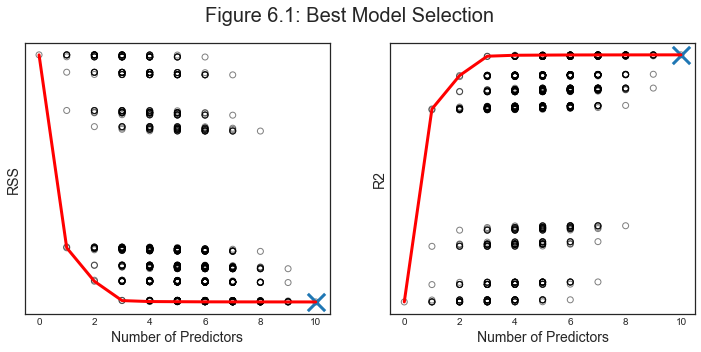

In [8]:
# Figure 6.1
fig, (ax1,ax2) = plt.subplots(1,2)
fig.suptitle('Figure 6.1: Best Model Selection')

# RSS
ax1.scatter(x=ms_RSS[:,0], y=ms_RSS[:,1], facecolors='None', edgecolors='k', alpha=0.5);
ax1.plot(range(K+1), ms_RSS_best, c='r');
ax1.scatter(np.argmin(ms_RSS_best), np.min(ms_RSS_best), marker='x', s=300)
ax1.set_ylabel('RSS');

# R2
ax2.scatter(x=ms_R2[:,0], y=ms_R2[:,1], facecolors='None', edgecolors='k', alpha=0.5);
ax2.plot(range(K+1), ms_R2_best, c='r');
ax2.scatter(np.argmax(ms_R2_best), np.max(ms_R2_best), marker='x', s=300)
ax2.set_ylabel('R2');

# All axes;
for ax in fig.axes:
    ax.set_xlabel('Number of Predictors'); 
    ax.set_yticks([]);

The figure shows that, as expected, these quantities improve as the number of variables increases; however, from the three-variable model on, there is little improvement in RSS and $R^2$ as a result of including additional predictors.

#### Forward Stepwise Selection

For computational reasons, best subset selection cannot be applied with very large $p$.

While the best subset selection procedure considers all $2^p$ possible models containing subsets of the p predictors, forward step-wise considers a much smaller set of models. Forward stepwise selection begins with a model containing no predictors, and then adds predictors to the model, one-at-a-time, until all of the predictors are in the model. In particular, at each step the variable that gives the greatest additional improvement to the fit is added to the model. 

In [9]:
def forward_selection(X, y, f):

    # Init RSS and R2
    K = np.shape(X)[1]
    fms_scores = np.zeros((K,1))
    
    # Categorical variables 
    categ_cols = {"Gender", "Student", "Married", "Ethnicity"}

    # Loop over p
    selected_cols = []
    for k in range(1,K+1):

        # Loop over selected columns
        remaining_cols = [col for col in X.columns if col not in selected_cols]
        temp_scores = np.zeros((0,1))

        # Loop on remaining columns    
        for col in remaining_cols:
            # Subset X
            X_subset = X.loc[:,selected_cols + [col]]
            if k>0:
                categ_subset = list(categ_cols & set(X_subset.columns))
                X_subset = pd.get_dummies(X_subset, columns=categ_subset, drop_first=True)

            # Regress
            reg = OLS(y,add_constant(X_subset).values).fit()

            # Metrics
            temp_scores = np.append(temp_scores, f(reg))

        # Pick best variable
        best_col = remaining_cols[np.argmin(temp_scores)]
        print(best_col)
        selected_cols += [best_col]
        fms_scores[k-1] = np.min(temp_scores)
        
    return fms_scores

In [10]:
# Forward selection by RSS
rss = lambda reg : reg.ssr
fms_RSS = forward_selection(X, y, rss)

Rating
Income
Student
Limit
Cards
Age
Ethnicity
Gender
Married
Education


In [11]:
# Forward selection by R2
r2 = lambda reg : -reg.rsquared
fms_R2 = -forward_selection(X, y, r2)

Rating
Income
Student
Limit
Cards
Age
Ethnicity
Gender
Married
Education


Unsurprisingly, both methods select the same models. Why? In the end $R^2$ is just a normalized version of RSS.

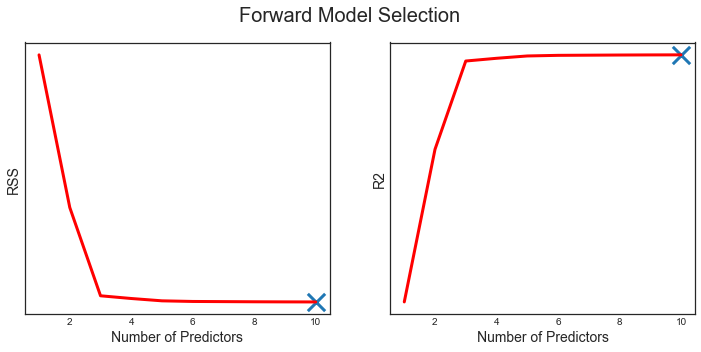

In [12]:
fig, (ax1,ax2) = plt.subplots(1,2)
fig.suptitle('Forward Model Selection')

# RSS
ax1.plot(range(1,K+1), fms_RSS, c='r');
ax1.scatter(np.argmin(fms_RSS)+1, np.min(fms_RSS), marker='x', s=300)
ax1.set_ylabel('RSS');

# R2
ax2.plot(range(1,K+1), fms_R2, c='r');
ax2.scatter(np.argmax(fms_R2)+1, np.max(fms_R2), marker='x', s=300)
ax2.set_ylabel('R2');

# All axes;
for ax in fig.axes:
    ax.set_xlabel('Number of Predictors'); 
    ax.set_yticks([]);

#### Backward Stepwise Selection

Like forward stepwise selection, backward stepwise selection provides an efficient alternative to best subset selection. However, unlike forward stepwise selection, it begins with the full least squares model containing all p predictors, and then iteratively removes the least useful predictor, one-at-a-time.

In [13]:
def backward_selection(X, y, f):

    # Init RSS and R2
    K = np.shape(X)[1]
    fms_scores = np.zeros((K,1))
    
    # Categorical variables 
    categ_cols = {"Gender", "Student", "Married", "Ethnicity"}

    # Loop over p
    selected_cols = list(X.columns)
    for k in range(K,0,-1):

        # Loop over selected columns
        temp_scores = np.zeros((0,1))

        # Loop on remaining columns    
        for col in selected_cols:
            # Subset X
            X_subset = X.loc[:,[x for x in selected_cols if x != col]]
            if k>1:
                categ_subset = list(categ_cols & set(X_subset.columns))
                X_subset = pd.get_dummies(X_subset, columns=categ_subset, drop_first=True)

            # Regress
            reg = OLS(y,add_constant(X_subset).values).fit()

            # Metrics
            temp_scores = np.append(temp_scores, f(reg))

        # Pick best variable
        worst_col = selected_cols[np.argmin(temp_scores)]
        print(worst_col)
        selected_cols.remove(worst_col)
        fms_scores[k-1] = np.min(temp_scores)
        
    return fms_scores

In [14]:
# Backward selection by RSS
rss = lambda reg : reg.ssr
bms_RSS = backward_selection(X, y, rss)

Education
Married
Gender
Ethnicity
Age
Rating
Cards
Student
Income
Limit


In [15]:
# Backward selection by R2
r2 = lambda reg : -reg.rsquared
bms_R2 = -backward_selection(X, y, r2)

Education
Married
Gender
Ethnicity
Age
Rating
Cards
Student
Income
Limit


The interesting part here is that the the variable `Rating` that was selected first by forward model selection, is now dropped $5^{th}$ to last. Why? It's probably because it contains a lot of information by itself (hence first in FMS) but it's highly correlated with `Student`, `Income` and `Limit` while these variables are more ortogonal to each other, and hence it gets dropped before them in BMS. 

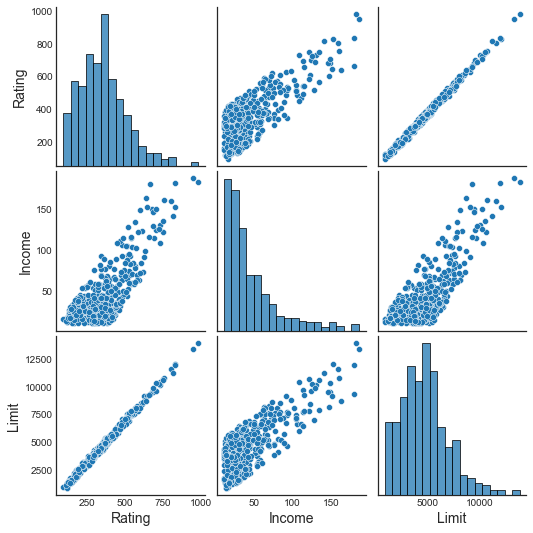

In [32]:
# Plot correlations
sns.pairplot(credit[['Rating','Student','Income','Limit']]);

If is indeed what we see: `Rating` and `Limit` are highly correlated.

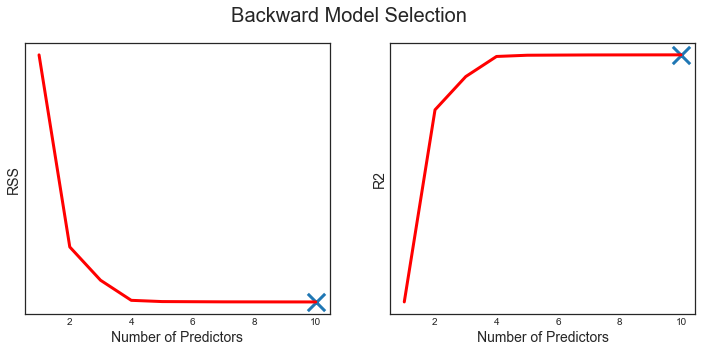

In [16]:
fig, (ax1,ax2) = plt.subplots(1,2)
fig.suptitle('Backward Model Selection')

# RSS
ax1.plot(range(1,K+1), bms_RSS, c='r');
ax1.scatter(np.argmin(bms_RSS)+1, np.min(bms_RSS), marker='x', s=300)
ax1.set_ylabel('RSS');

# R2
ax2.plot(range(1,K+1), bms_R2, c='r');
ax2.scatter(np.argmax(bms_R2)+1, np.max(bms_R2), marker='x', s=300)
ax2.set_ylabel('R2');

# All axes;
for ax in fig.axes:
    ax.set_xlabel('Number of Predictors'); 
    ax.set_yticks([]);

#### Choosing the Optimal Model

So far we have use the trainint error in order to select the model. However, the training error can be a poor estimate of the test error. Therefore, RSS and R2 are not suitable for selecting the best model among a collection of models with different numbers of predictors.

In order to select the best model with respect to test error, we need to estimate this test error. There are two common approaches:

1. We can indirectly estimate test error by making an adjustment to the training error to account for the bias due to overfitting. 
2. We can directly estimate the test error, using either a validation set approach or a cross-validation approach.

Some metrics that account for the trainint error are

- Akaike Information Criterium (AIC)
- Bayesian Information Criterium (BIC)
- Adjusted $R^2$

The idea behind all these varaibles is to insert a penalty for the number of parameters used in the model. All these measure have theoretical fundations which are beyond the scope of this session.

We are now going to test the three metrics

In [17]:
# Set metrics
aic = lambda reg : reg.aic
bic = lambda reg : reg.bic
r2a = lambda reg : reg.rsquared_adj

# Compute best model selection scores
scores = model_selection(X, y, aic, bic, r2a)
ms_AIC = scores[0]
ms_BIC = scores[1]
ms_R2a = scores[2]

In [18]:
# Save best scores
ms_AIC_best = [np.min(ms_AIC[ms_AIC[:,0]==k,1]) for k in range(K+1)]
ms_BIC_best = [np.min(ms_BIC[ms_BIC[:,0]==k,1]) for k in range(K+1)]
ms_R2a_best = [np.max(ms_R2a[ms_R2a[:,0]==k,1]) for k in range(K+1)]

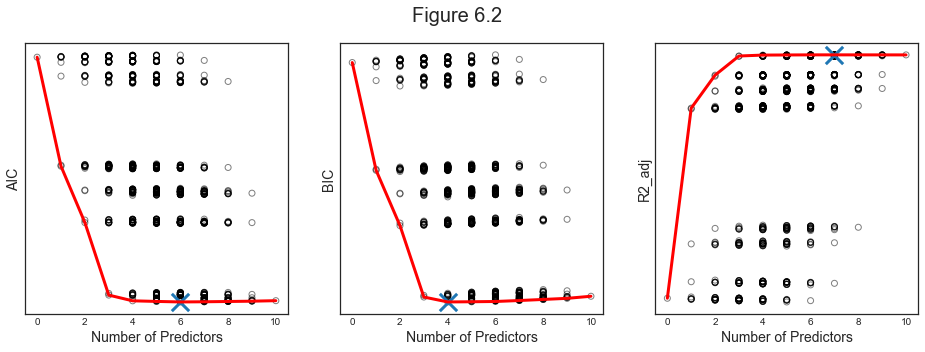

In [19]:
# Figure 6.2
fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(16,5))
fig.suptitle('Figure 6.2')

# AIC
ax1.scatter(x=ms_AIC[:,0], y=ms_AIC[:,1], facecolors='None', edgecolors='k', alpha=0.5);
ax1.plot(range(K+1),ms_AIC_best, c='r');
ax1.scatter(np.argmin(ms_AIC_best), np.min(ms_AIC_best), marker='x', s=300)
ax1.set_ylabel('AIC');

# BIC
ax2.scatter(x=ms_BIC[:,0], y=ms_BIC[:,1], facecolors='None', edgecolors='k', alpha=0.5);
ax2.plot(range(K+1), ms_BIC_best, c='r');
ax2.scatter(np.argmin(ms_BIC_best), np.min(ms_BIC_best), marker='x', s=300)
ax2.set_ylabel('BIC');

# R2 adj
ax3.scatter(x=ms_R2a[:,0], y=ms_R2a[:,1], facecolors='None', edgecolors='k', alpha=0.5);
ax3.plot(range(K+1), ms_R2a_best, c='r');
ax3.scatter(np.argmax(ms_R2a_best), np.max(ms_R2a_best), marker='x', s=300)
ax3.set_ylabel('R2_adj');

# All axes;
for ax in fig.axes:
    ax.set_xlabel('Number of Predictors'); 
    ax.set_yticks([]);

As we can see, all three metrics select more parsimonious models, with BIC being particularly conservative with only 4 varaibles and $R^2_{adj}$ selecting the righer model with 7 variables.

#### Validation and Cross-validation

As an alternative to the approaches just discussed, we can directly esti- mate the test error using the validation set and cross-validation methods discussed in the previous session.

The main problem with cross-validation is the computational burden. We are now going to perform *best model selection* using the following cross-validation algorithms:

 - Validation set approach, 50-50 split, repeated 10 times
 - 5-fold cross-validation
 - 10-fold cross-validation
 
We are not going to perform Leave-One-Out cross-validation for computational reasons.

In [20]:
def cv_scores(X, y, *args):

    # Init 
    scores = list(itertools.repeat(np.zeros((0,2)), len(args)))

    # Categorical variables 
    categ_cols = {"Gender", "Student", "Married", "Ethnicity"}

    # Loop over all possible combinations of regressions
    K = np.shape(X)[1]
    for k in range(K+1):
        print("Computing k=%1.0f" % k, end ="")
        for i in combinations(range(K), k):

            # Subset X
            X_subset = X.iloc[:,list(i)]

            # Get dummies for categorical variables
            if k>0:
                categ_subset = list(categ_cols & set(X_subset.columns))
                X_subset = pd.get_dummies(X_subset, columns=categ_subset, drop_first=True)

            # Metrics
            for i,cv_method in enumerate(args):
                score = cross_val_score(LinearRegression(), add_constant(X_subset), y, 
                                        cv=cv_method, scoring='neg_mean_squared_error').mean()
                score_pair = np.reshape([k,score], (1,-1))
                scores[i] = np.append(scores[i], score_pair, axis=0)
        print("", end="\r")
                
    return scores

In [21]:
# Define cv methods
vset = ShuffleSplit(n_splits=10, test_size=0.5)
kf5 = KFold(n_splits=5, shuffle=True)
kf10 = KFold(n_splits=10, shuffle=True)

# Get best model selection scores
scores = cv_scores(X, y, vset, kf5, kf10)
ms_vset = scores[0]
ms_kf5 = scores[1]
ms_kf10 = scores[2]

In [22]:
# Save best scores
ms_vset_best = [np.max(ms_vset[ms_vset[:,0]==k,1]) for k in range(K+1)]
ms_kf5_best = [np.max(ms_kf5[ms_kf5[:,0]==k,1]) for k in range(K+1)]
ms_kf10_best = [np.max(ms_kf10[ms_kf10[:,0]==k,1]) for k in range(K+1)]

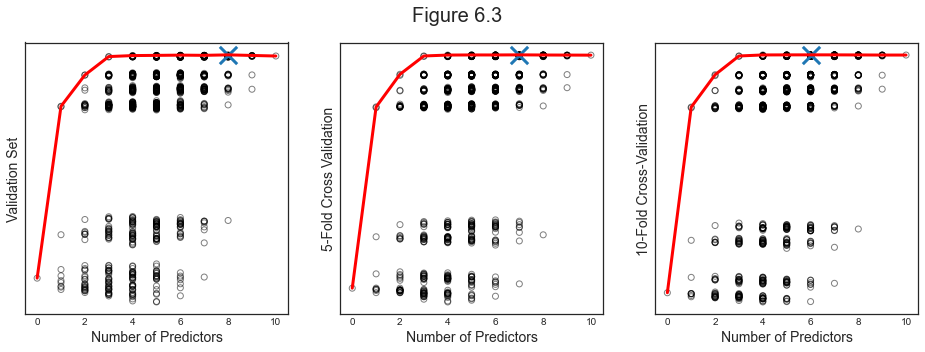

In [23]:
# Figure 6.3
fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(16,5))
fig.suptitle('Figure 6.3')

# Validation Set
ax1.scatter(x=ms_vset[:,0], y=ms_vset[:,1], facecolors='None', edgecolors='k', alpha=0.5);
ax1.plot(range(K+1),ms_vset_best, c='r');
ax1.scatter(np.argmax(ms_vset_best), np.max(ms_vset_best), marker='x', s=300)
ax1.set_ylabel('Validation Set');


# 5-Fold Cross Validation
ax2.scatter(x=ms_kf5[:,0], y=ms_kf5[:,1], facecolors='None', edgecolors='k', alpha=0.5);
ax2.plot(range(K+1), ms_kf5_best, c='r');
ax2.scatter(np.argmax(ms_kf5_best), np.max(ms_kf5_best), marker='x', s=300)
ax2.set_ylabel('5-Fold Cross Validation');


# 10-Fold Cross-Validation
ax3.scatter(x=ms_kf10[:,0], y=ms_kf10[:,1], facecolors='None', edgecolors='k', alpha=0.5);
ax3.plot(range(K+1), ms_kf10_best, c='r');
ax3.scatter(np.argmax(ms_kf10_best), np.max(ms_kf10_best), marker='x', s=300)
ax3.set_ylabel('10-Fold Cross-Validation');

# All axes;
for ax in fig.axes:
    ax.set_xlabel('Number of Predictors'); 
    ax.set_yticks([]);

From the figure we see that each cross-validation method selects a different model and the most accurate one, K-fold CV, select 5 predictors.

## Shrinkage Methods

Model selection methods constrained the number of varaibles *before* running a linear regression. Shrinkage methods attempt to do the two things simultaneously. In particular they *constrain* or *shrink* coefficients by imposing penalties in the objective functions for high values of the parameters.

### Ridge Regression

The Least Squares Regression minimizes the Residual Sum of Squares

$$
\mathrm{RSS}=\sum_{i=1}^{n}\left(y_{i}-\beta_{0}-\sum_{j=1}^{p} \beta_{j} x_{i j}\right)^{2}
$$

The Ridge Regression objective function instead is

$$
\sum_{i=1}^{n}\left(y_{i}-\beta_{0}-\sum_{j=1}^{p} \beta_{j} x_{i j}\right)^{2}+\lambda \sum_{j=1}^{p} \beta_{j}^{2}=\mathrm{RSS}+\lambda \sum_{j=1}^{p} \beta_{j}^{2}
$$

where $\lambda>0$ is a tuning parameter that regulates the extent to which large parameters are penalized. 

In matrix notation, the objective function is

$$ 
||X\beta - y||^2_2 + \alpha ||\beta||^2_2 
$$

which is equivalent to optimizing

$$ 
\frac{1}{N}||X\beta - y||^2_2 + \frac{\alpha}{N} ||\beta||^2_2 
$$

We are now going to run Ridge Regression on the `Credit` dataset trying to explain account `Balance` with a set of observable individual characteristics.

In [24]:
# X and y
categ_cols = ["Gender", "Student", "Married", "Ethnicity"]
X = credit.loc[:, credit.columns != 'Balance']
X = pd.get_dummies(X, columns=categ_cols, drop_first=True)
y = credit.loc[:,'Balance']
n = len(credit)

We run ridge regression over a range of values for the penalty paramenter $\lambda$.

In [25]:
# Init alpha grid
n_grid = 100
alphas = 10**np.linspace(-2,5,n_grid).reshape(-1,1)
ridge = Ridge()
ridge_coefs = []

# Loop over values of alpha
for a in alphas:
    ridge.set_params(alpha=a)
    ridge.fit(scale(X), y)
    ridge_coefs.append(ridge.coef_)
ridge_coefs = np.reshape(ridge_coefs,(n_grid,-1))

We use linear regression as a comparison.

In [26]:
# OLS regression
ols = LinearRegression().fit(scale(X),y)
ols_coefs = ols.coef_;
mod_ols = np.linalg.norm(ols_coefs)

# Relative magnitude
rel_beta = [np.linalg.norm(ridge_coefs[k,:])/mod_ols for k in range(n_grid)]
rel_beta = np.reshape(rel_beta, (-1,1))

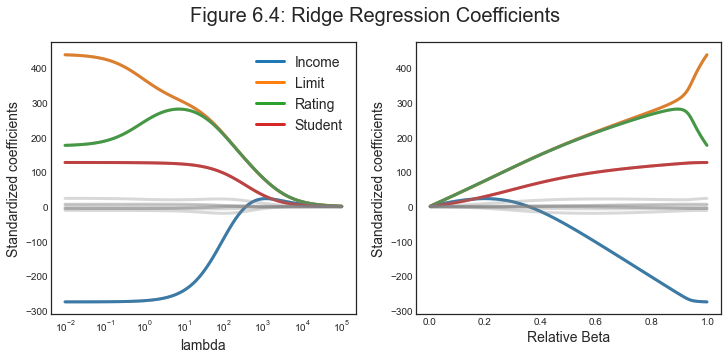

In [27]:
# Figure 6.4
fig, (ax1,ax2) = plt.subplots(1,2)
fig.suptitle('Figure 6.4: Ridge Regression Coefficients')

highlight = [0,1,2,7];

# Plot coefficients - absolute
ax1.plot(alphas, ridge_coefs[:,highlight], alpha=1)
ax1.plot(alphas, ridge_coefs, c='grey', alpha=0.3)
ax1.set_xscale('log')
ax1.set_xlabel('lambda'); ax1.set_ylabel('Standardized coefficients');
ax1.legend(['Income', 'Limit', 'Rating', 'Student'])

# Plot coefficients - relative
ax2.plot(rel_beta, ridge_coefs[:,highlight], alpha=1)
ax2.plot(rel_beta, ridge_coefs, c='grey', alpha=0.3)
ax2.set_xlabel('Relative Beta'); ax2.set_ylabel('Standardized coefficients');

The above plot shows that the Ridge coefficients get larger when we decrease alpha.

#### Bias-Variance Trade-off

Ridge regression’s advantage over least squares is rooted in the bias-variance trade-off. As $\lambda$ increases, the flexibility of the ridge regression fit decreases, leading to decreased variance but increased bias.

$$
y_0 = f(x_0) + \varepsilon
$$

Recap: we can decompose the Mean Squared Error of an estimator into two components: the *variance* and the squared *bias*:

$$
\mathbb E\left(y_{0}-\hat{f}\left(x_{0}\right)\right)^{2} = \mathbb E\left(f(x_0) + \varepsilon - \hat f(x_{0})\right)^{2} = \\
= \mathbb E\left(f(x_0) - \mathbb E[\hat f(x_{0})] + \varepsilon - \hat f(x_{0}) + \mathbb E[\hat f(x_{0})] \right)^{2} = \\
= \mathbb E \left[ \mathbb E [\hat{f} (x_{0}) ] - f(x_0) \right]^2 + \mathbb E \left[ \left( \hat{f} (x_{0}) - \mathbb E [\hat{f} (x_{0})] \right)^2 \right] + \mathbb E[\varepsilon^2] \\
= \operatorname{Bias} \left( \hat{f} (x_{0}) \right)^2 + \operatorname{Var}\left(\hat{f}\left(x_{0}\right)\right) + \operatorname{Var}(\varepsilon)
$$

The last term is the variance of the error term, sometimes also called the *irreducible error* since it's pure noise, and we cannot account for it.

In [28]:
# Compute var-bias
def compute_var_bias(X_train, b0, x0, a, k, n, sim, f):
    
    # Init 
    y_hat = np.zeros(sim)
    coefs = np.zeros((sim, k))
    
    # Loop over simulations
    for s in range(sim):
        e_train = normal(0,1,(n,1))
        y_train = X_train @ b0 + e_train
        fit = f(a).fit(X_train, y_train)
        y_hat[s] = fit.predict(x0)
        coefs[s,:] = fit.coef_
        
    # Compute MSE, Var and Bias2   
    e_test = normal(0,1,(sim,1))
    y_test = x0 @ b0 + e_test
    mse = np.mean((y_test - y_hat)**2)
    var = np.var(y_hat)
    bias2 = np.mean(x0 @ b0 - y_hat)**2
    
    return [mse, var, bias2], np.mean(coefs, axis=0)

In [29]:
np.random.seed(1)

# Generate random data
n = 50
k = 45
N = 50000
X_train = normal(0.2,1,(n,k))
x0 = normal(0.2,1,(1,k))
e_train = normal(0,1,(n,1))
b0 = uniform(0,1,(k,1))

In [30]:
# Init alpha grid
sim = 1000
n_grid = 30
df = pd.DataFrame({'alpha':10**np.linspace(-5,5,n_grid)})
ridge_coefs2 = []

# Init simulations
sim = 1000
ridge = lambda a: Ridge(alpha=a, fit_intercept=False)

# Loop over values of alpha
for i in range(len(df)):
    print("Alpha %1.0f/%1.0f" % (i+1,len(df)), end ="")
    a = df.loc[i,'alpha']
    df.loc[i,['mse','var','bias2']], c = compute_var_bias(X_train, b0, x0, a, k, n, sim, ridge)
    ridge_coefs2.append(c)
    print("", end="\r")
ridge_coefs2 = np.reshape(ridge_coefs2,(n_grid,-1))

NameError: name 'coefs' is not defined

In [ ]:
# OLS regression
y_train = X_train @ b0 + e_train
ols = LinearRegression().fit(X_train,y_train)
ols_coefs = ols.coef_;
mod_ols = np.linalg.norm(ols_coefs)

# Relative magnitude
rel_beta = [np.linalg.norm(ridge_coefs2[i,:])/mod_ols for i in range(n_grid)]
rel_beta = np.reshape(rel_beta, (-1,1))

In [ ]:
# Figure 6.5
fig, (ax1,ax2) = plt.subplots(1,2)
fig.suptitle('Figure 6.5: Ridge Bias-Var decomposition')

# MSE
ax1.plot(df['alpha'], df[['bias2','var','mse']]);
ax1.set_xscale('log');
ax1.set_xlabel('lambda'); ax1.set_ylabel('Mean Squared Error');
ax1.legend(['Bias2','Variance','MSE'], fontsize=12);

# MSE
ax2.plot(rel_beta, df[['bias2','var','mse']]);
ax2.set_xlabel('Relative Beta'); ax2.set_ylabel('Mean Squared Error');
ax2.legend(['Bias2','Variance','MSE'], fontsize=12);

Ridge regression has the advantage of shrinking coefficients. However, unlike best subset, forward stepwise, and backward stepwise selection, which will generally select models that involve just a subset of the variables, ridge regression will include all $p$ predictors in the final model.

Lasso solves that problem by using a different penalty function.

### Lasso

The lasso coefficients minimize the following objective function:

$$
\sum_{i=1}^{n}\left(y_{i}-\beta_{0}-\sum_{j=1}^{p} \beta_{j} x_{i j}\right)^{2}+\lambda \sum_{j=1}^{p}\left|\beta_{j}\right| = \mathrm{RSS} + \lambda \sum_{j=1}^p|\beta_j|
$$

so that the main difference with respect to ridge regression is the penalty function $\lambda \sum_{j=1}^{p}\left|\beta_{j}\right|$ instead of $\lambda \sum_{j=1}^p (\beta_j)^2$.

A consequence of this objective function is that Lasso is much more likely to shrink coefficients to exactly zero, while Ridge only decreases their magnitude. The reason why lies in the shape of the objective function. You can rewrite the Ridge and Lasso minimization problems as constrained optimization:

- Ridge
$$
\underset{\beta}{\operatorname{min}} \ \left\{\sum_{i=1}^{n}\left(y_{i}-\beta_{0}-\sum_{j=1}^{p} \beta_{j} x_{i j}\right)^{2}\right\} \quad \text { subject to } \quad \sum_{j=1}^{p}\left|\beta_{j}\right| \leq s
$$

- Lasso
$$
\underset{\beta}{\operatorname{min}} \ \left\{\sum_{i=1}^{n}\left(y_{i}-\beta_{0}-\sum_{j=1}^{p} \beta_{j} x_{i j}\right)^{2}\right\} \quad \text { subject to } \quad \sum_{j=1}^{p} \beta_{j}^{2} \leq s
$$

In pictures, constrained optimization problem lookes like this.

<img src="figures/ridgelasso.png" alt="Drawing" style="width: 600px;"/>

The red curves represents the contour sets of the RSS. They are elliptical since the objective function is quadratic. The blue area represents the admissible set, i.e. the constraints. As we can see, it is much easier with Lasso to have the constrained optimum on one of the edges of the rhombus.

We are now going to repeat the same exercise on the `Credit` dataset, trying to predict account `Balance` with a set of obsevable induvidual characteristics, for different values of the penalty paramenter $\lambda$.

In [ ]:
# X and y
categ_cols = ["Gender", "Student", "Married", "Ethnicity"]
X = credit.loc[:, credit.columns != 'Balance']
X = pd.get_dummies(X, columns=categ_cols, drop_first=True)
y = credit.loc[:,'Balance']

The $\lambda$ grid is going to be slightly different now.

In [ ]:
# Init alpha grid
n_grid = 100
alphas = 10**np.linspace(0,3,n_grid).reshape(-1,1)
lasso = Lasso()
lasso_coefs = []

# Loop over values of alpha
for a in alphas:
    lasso.set_params(alpha=a)
    lasso.fit(scale(X), y)
    lasso_coefs.append(lasso.coef_)
lasso_coefs = np.reshape(lasso_coefs,(n_grid,-1))

We run OLS to plot the relative magnitude of the Lasso coefficients.

In [ ]:
# Relative magnitude
mod_ols = np.linalg.norm(ols_coefs)
rel_beta = [np.linalg.norm(lasso_coefs[i,:])/mod_ols for i in range(n_grid)]
rel_beta = np.reshape(rel_beta, (-1,1))

In [ ]:
# Figure 6.6
fig, (ax1,ax2) = plt.subplots(1,2)
fig.suptitle('Figure 6.6')

highlight = [0,1,2,7];

# Plot coefficients - absolute
ax1.plot(alphas, lasso_coefs[:,highlight], alpha=1)
ax1.plot(alphas, lasso_coefs, c='grey', alpha=0.3)
ax1.set_xscale('log')
ax1.set_xlabel('lambda'); ax1.set_ylabel('Standardized coefficients');
ax1.legend(['Income', 'Limit', 'Rating', 'Student'], fontsize=12)

# Plot coefficients - relative
ax2.plot(rel_beta, lasso_coefs[:,highlight], alpha=1)
ax2.plot(rel_beta, lasso_coefs, c='grey', alpha=0.3)
ax2.set_xlabel('relative mod beta'); ax2.set_ylabel('Standardized coefficients');

As with ridge regression, the lasso shrinks the coefficient estimates towards zero. However, in the case of the lasso, the $l_1$ penalty has the effect of forcing some of the coefficient estimates to be exactly equal to zero when the tuning parameter $\lambda$ is sufficiently large. Hence, much like best subset selection, the lasso performs variable selection. 

We say that the lasso yields **sparse** models — that is, models that involve only a subset of the variable

In [ ]:
# Init alpha grid
sim = 1000
n_grid = 30
df = pd.DataFrame({'alpha':10**np.linspace(-1,1,n_grid)})
lasso_coefs2 = []

# Init simulations
sim = 1000
lasso = lambda a: Lasso(alpha=a, fit_intercept=False)

# Loop over values of alpha
for i in range(len(df)):
    print("Alpha %1.0f/%1.0f" % (i+1,len(df)), end ="")
    a = df.loc[i,'alpha']
    df.loc[i,['mse','var','bias2']], c = compute_var_bias(X_train, b0, x0, a, k, n, sim, lasso)
    lasso_coefs2.append(c)
    print("", end="\r")
lasso_coefs2 = np.reshape(lasso_coefs2,(n_grid,-1))

In [ ]:
# Relative magnitude
mod_ols = np.linalg.norm(ols_coefs)
rel_beta = [np.linalg.norm(lasso_coefs2[k,:])/mod_ols for k in range(n_grid)]
rel_beta = np.reshape(rel_beta, (-1,1))

In [ ]:
# OLS regression
y_train = X_train @ b0 + e_train
ols = LinearRegression().fit(X_train,y_train)
ols_coefs = ols.coef_;
mod_ols = np.linalg.norm(ols_coefs)

# Relative magnitude
mod_ols = np.linalg.norm(ols_coefs)
rel_beta = [np.linalg.norm(coefs[k,:])/mod_ols for k in range(n_grid)]
rel_beta = np.reshape(rel_beta, (-1,1))

In [ ]:
# Figure 6.8
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(12,5))
fig.suptitle('Figure 6.8: Lasso Bias-Var decomposition')

# MSE
ax1.plot(df['alpha'], df[['bias2','var','mse']]);
ax1.set_xscale('log');
ax1.set_xlabel('lambda'); ax1.set_ylabel('Mean Squared Error');
ax1.legend(['Bias2','Variance','MSE'], fontsize=12);

# MSE
ax2.plot(rel_beta, df[['bias2','var','mse']]);
ax2.set_xlabel('Relative Beta'); ax1.set_ylabel('Mean Squared Error');
ax2.legend(['Bias2','Variance','MSE'], fontsize=12);

#### Comparing the Lasso and Ridge Regression

In order to obtain a better intuition about the behavior of ridge regression and the lasso, consider a simple special case with $n = p$, and $X$ a diagonal matrix with $1$’s on the diagonal and $0$’s in all off-diagonal elements. To simplify the problem further, assume also that we are performing regression without an intercept.

With these assumptions, the usual least squares problem simplifies to the coefficients that minimize 

$$
\sum_{j=1}^{p}\left(y_{j}-\beta_{j}\right)^{2}
$$

In this case, the least squares solution is given by

$$
\hat \beta_j = y_j
$$

One can show that in this setting, the ridge regression estimates take the form 

$$
\hat \beta_j^{RIDGE} = \frac{y_j}{1+\lambda}
$$

and the lasso estimates take the form

$$
\hat{\beta}_{j}^{LASSO}=\left\{\begin{array}{ll}
y_{j}-\lambda / 2 & \text { if } y_{j}>\lambda / 2 \\
y_{j}+\lambda / 2 & \text { if } y_{j}<-\lambda / 2 \\
0 & \text { if }\left|y_{j}\right| \leq \lambda / 2
\end{array}\right.
$$

We now plot the relationship visually.

In [ ]:
np.random.seed(3)

# Generate random data
n = 100
k = n
X = np.eye(k)
e = normal(0,1,(n,1))
b0 = uniform(-1,1,(k,1))
y = X @ b0 + e

In [ ]:
# OLS regression
reg = LinearRegression().fit(X,y)
ols_coefs = reg.coef_;

# Ridge regression
ridge = Ridge(alpha=1).fit(X,y)
ridge_coefs = ridge.coef_;

# Ridge regression
lasso = Lasso(alpha=0.01).fit(X,y)
lasso_coefs = lasso.coef_.reshape(1,-1);

# sort
order = np.argsort(y.reshape(1,-1), axis=1)
y_sorted = np.take_along_axis(ols_coefs, order, axis=1) 
ols_coefs = np.take_along_axis(ols_coefs, order, axis=1) 
ridge_coefs = np.take_along_axis(ridge_coefs, order, axis=1) 
lasso_coefs = np.take_along_axis(lasso_coefs, order, axis=1) 

In [ ]:
# Figure 6.10
fig, (ax1,ax2) = plt.subplots(1,2)
fig.suptitle('Figure 6.10')

# Ridge
ax1.plot(y_sorted.T, ols_coefs.T)
ax1.plot(y_sorted.T, ridge_coefs.T)
ax1.set_xlabel('True Coefficient'); ax1.set_ylabel('Estimated Coefficient');
ax1.legend(['OLS','Ridge'], fontsize=12);

# Lasso
ax2.plot(y_sorted.T, ols_coefs.T)
ax2.plot(y_sorted.T, lasso_coefs.T)
ax2.set_xlabel('True Coefficient'); ax2.set_ylabel('Estimated Coefficient');
ax2.legend(['OLS','Lasso'], fontsize=12);

We see that ridge regression more or less shrinks every dimension of the data by the same proportion, whereas the lasso more or less shrinks all coefficients toward zero by a similar amount, and sufficiently small coefficients are shrunken all the way to zero.

### Selecting the Tuning Parameter

Implementing ridge regression and the lasso requires a method for selecting a value for the tuning parameter $\lambda$.

Cross-validation provides a simple way to tackle this problem. We choose a grid of $\lambda$ values, and compute the cross-validation error for each value of $\lambda$. We then select the tuning parameter value for which the cross-validation error is smallest. Finally, the model is re-fit using all of the available observations and the selected value of the tuning parameter.

In [ ]:
# X and y
categ_cols = ["Gender", "Student", "Married", "Ethnicity"]
X = credit.loc[:, credit.columns != 'Balance']
X = pd.get_dummies(X, columns=categ_cols, drop_first=True).values
y = credit.loc[:,'Balance']
n = len(credit)

We are going to use 10-fold CV as cross-validation algorithm.

In [ ]:
# Get MSE
def cv_lasso(X,y,a):
    # Init mse
    mse = []
    
    # Generate splits
    kf10 = KFold(n_splits=10, random_state=None, shuffle=False)
    kf10.get_n_splits(X)
    
    # Loop over splits
    for train_index, test_index in kf10.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        lasso = Lasso(alpha=a).fit(X_train, y_train)
        y_hat = lasso.predict(X_test)
        mse.append(mean_squared_error(y_test, y_hat))
    return np.mean(mse)

In [ ]:
# Compute MSE over grid of alphas
n_grid = 30
alphas = 10**np.linspace(0,3,n_grid).reshape(-1,1)
MSE = [cv_lasso(X,y,a) for a in alphas]

In [ ]:
# Find minimum alpha
alpha_min = alphas[np.argmin(MSE)]
print('Best alpha by 10fold CV:',alpha_min[0])

In [ ]:
# Get coefficients
coefs = []

# Loop over values of alpha
for a in alphas:
    lasso = Lasso(alpha=a).fit(scale(X), y)
    coefs.append(lasso.coef_)
coefs = np.reshape(coefs,(n_grid,-1))

In [ ]:
# Figure 6.12
fig, (ax1,ax2) = plt.subplots(1,2)
fig.suptitle('Figure 6.12: Lasso 10-fold CV')

# MSE by LOO CV
ax1.plot(alphas, MSE, alpha=1);
ax1.axvline(alpha_min, c='k', ls='--')
ax1.set_xscale('log')
ax1.set_xlabel('lambda'); ax1.set_ylabel('MSE');

highlight = [0,1,2,7];

# Plot coefficients - absolute
ax2.plot(alphas, coefs[:,highlight], alpha=1)
ax2.plot(alphas, coefs, c='grey', alpha=0.3)
ax2.axvline(alpha_min, c='k', ls='--')
ax2.set_xscale('log')
ax2.set_xlabel('lambda'); ax2.set_ylabel('Standardized coefficients');
ax2.legend(['Income', 'Limit', 'Rating', 'Student'], fontsize=10);

## Next Lecture

Jump to [Session 6 - Convexity and Optimization](https://nbviewer.jupyter.org/github/matteocourthoud/Machine-Learning-for-Economic-Analysis-2020/blob/master/6_convexity.ipynb)